# SMS Chat Analysis 
***


## Goals

The goal of this project is to experiment with various NLP methods on an SMS Text dataset and gather informative insights.

## Data

The National University of Singapore SMS Corpus dataset, made publicly available by The National University of Singapore.  This corpus was collected by Tao Chen and Min-Yen Kan.

* **id:**  Unique identifier for each message.<br>
* **Message:**	   The message contents.<br>
* **length:**	   Total number of characters in the message.<br>
* **country:**	   Country the sender is from.<br>
* **Date:**	    Month and Year a message was sent.<br>

## Questions 

- What is the overall sentiment of the text message as well as broken down by country?
- What are the most common topics/words?
- What are the most common words used by sentiment?


#### Importing libraries

In [1937]:
#Importing libraries    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn import svm
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, WordNetLemmatizer, pos_tag, RegexpParser 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

In [1938]:
pd.options.display.max_colwidth = 60
%matplotlib inline

#### Importing data

In [1939]:
#Importing data
data = pd.read_csv('clean_nus_sms.csv')
data.head()


,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


The dataset has 48,598 rows and 6 columns

In [1940]:
#Data shape
data.shape

(48598, 6)

The dataset has 39,463 unique message ids

In [1941]:
#Data unique id
data.id.nunique()

39463

In [1942]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


### Data Cleaning and Noise Removal

There are 3 blank messages.  We will drop these rows.

In [1943]:
data = data.dropna()

Filtering the dataset for messages that contain more than 1 character

In [1944]:
#filter dataframe for Message with more than 1 character
data = data[data['Message'].str.len() > 1]
data.shape

(48559, 6)

Creating a new column to contain 'cleaned' messages.  Converting all strings to lowercase.

In [1945]:
data['message_cleaned'] = data.Message.str.lower()

In [1946]:
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,"go until jurong point, crazy.. available only in bugis n..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price... haiz... cant eat ...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


Removing all punctuations from message_cleaned

In [1947]:
#create a function to remove punctuations
def remove_punct(txt):
    return re.sub(r'[^\w\s]', '', txt)

data['message_cleaned'] = data['message_cleaned'].apply(lambda x: remove_punct(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


Removing urls from messages

In [1948]:
#create a function to remove urls
def remove_url(txt):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',txt)

## Analyze

In [1949]:
#Removing urls
data['message_cleaned'] = data['message_cleaned'].apply(lambda x: remove_url(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


In [1950]:
#create a function to remove muliple periods 
# def remove_periods(txt):
#     return re.sub(r'\.{2,}', '', txt)

Tokenize messages and create new column 'message_tokenized'

In [1951]:
#create a function to tokenize messages 
def tokenize(txt):
    tokens = word_tokenize(txt)
    return tokens

In [1952]:
pd.set_option('display.max_columns', None)
#Tokenizing messages
data['message_tokenized'] = data['message_cleaned'].apply(lambda x: tokenize(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]"


Lemmatize messages and create new column

In [1953]:
#Lemmatize messages
lemmatizer = WordNetLemmatizer()
data['message_lemmatized'] = data.message_tokenized.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]"


In [1954]:
#create function to remove stop words  
stop_words = set(stopwords.words('english'))   
def remove_stopwords(txt):
    return [word for word in txt if word not in stop_words]

#create function to remove numbers 
def remove_numbers(txt):
    return [word for word in txt if not word.isdigit()]

#apply functions
data['message_lemmatized_nostop'] = data.message_lemmatized.apply(lambda x: remove_stopwords(x))
data['message_lemmatized_nostop'] = data.message_lemmatized_nostop.apply(lambda x: remove_numbers(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]"


View number of messages per country.  

In [1955]:
#view number of messages per country
data.country.value_counts()

country
Singapore              22010
SG                      9794
India                   6886
United States           3746
USA                     1931
Sri Lanka               1017
Malaysia                 766
Pakistan                 746
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Turkey                    10
Trinidad and Tobago       10
Lebanon                   10
Slovenia                  10
Nigeria                   10
New Zealand               10
Macedonia                 10
UK                        10
Morocco                    9
Romania                    9
Austra

Rename countries to clean up duplicates

In [1956]:
#clean country names
data = data.replace({'country': {'USA': 'United States', 
                                 'SG': 'Singapore', 
                                 'india': 'India', 
                                 'sri lanka': 'Sri Lanka', 
                                 'INDIA': 'India',
                                 'pakistan': 'Pakistan',
                                 'UK': 'United Kingdom',
                                 'jamaica': 'Jamaica',
                                 'MY': 'Malaysia',
                                 'srilanka': 'Sri Lanka',}})
data.country.value_counts()

country
Singapore              31804
India                   7070
United States           5677
Sri Lanka               1047
Malaysia                 767
Pakistan                 746
unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
BARBADOS                   8
Spain                      5
France                     5
Name: count, dtype: int64

There are 33 unique countries in this dataset and the vast majority of messages are from Singapore, followed by India and the United States

In [1957]:
#count the number of unique countries
data.country.nunique()

33

## Analyze

Visualize the number of messages sent per country

Text(0.5, 0, 'Number of Messages')

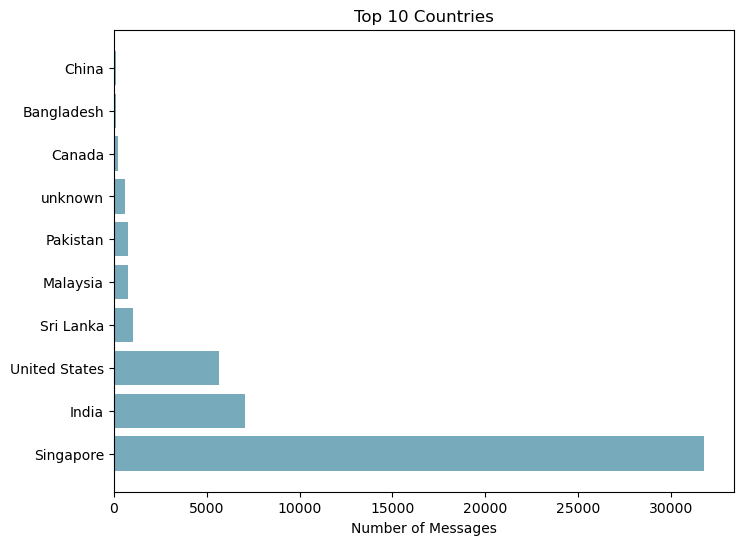

In [1958]:
#create dataframe of number of messages per country
country_messages = data.country.value_counts().reset_index()

top_10 = country_messages.head(10)
top_10
#plot top 10 countries
plt.figure(figsize=(8, 6))
plt.barh(top_10['country'], top_10['count'])
plt.title('Top 10 Countries')
plt.xlabel('Number of Messages')

Create a wordcloud from the 'cleaned' messages to visualize the most common words used.  The most frequent terms appear to be: 'haha', 'u', 'ok', 'lol', 'one', 'time', 'going', 'hey', 'got', 'today' and 'think'.

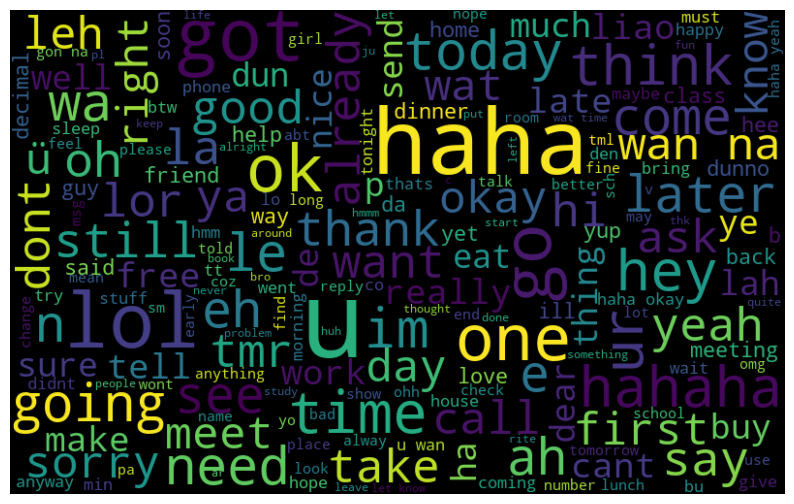

In [1959]:
#create wordcloud from message_lemmatized_nostop
all_words = ' '.join([' '.join(text) for text in data['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Creating a frequency distribution of the top words used

In [1960]:
#create frequency distribution of words
all_words_list = all_words.split(' ')
fdist = FreqDist(all_words_list)
fdist.most_common(20)

[('u', 10345),
 ('haha', 6514),
 ('go', 3349),
 ('lol', 2996),
 ('got', 2585),
 ('im', 2328),
 ('ok', 2265),
 ('time', 2072),
 ('okay', 1693),
 ('hahaha', 1665),
 ('ur', 1661),
 ('le', 1571),
 ('one', 1560),
 ('going', 1541),
 ('oh', 1467),
 ('hey', 1459),
 ('like', 1431),
 ('come', 1420),
 ('think', 1417),
 ('get', 1409)]

Tagging all words with Parts of Speech to gain further insights

In [1961]:
#find most common topics using pos tagging
all_words_list = all_words.split(' ')
pos_tagged = pos_tag(all_words_list)
pos_tagged[:10]


[('bugis', 'NN'),
 ('oso', 'NN'),
 ('near', 'IN'),
 ('wat', 'NN'),
 ('go', 'VBP'),
 ('jurong', 'JJ'),
 ('point', 'NN'),
 ('crazy', 'NN'),
 ('available', 'JJ'),
 ('bugis', 'NN')]

Extracting nouns to a separate list

In [1962]:
#extract nouns
nouns = [word for word, pos in pos_tagged if pos == 'NN']
nouns[:10]

['bugis',
 'oso',
 'wat',
 'point',
 'crazy',
 'bugis',
 'world',
 'la',
 'cine',
 'dunno']

Creating a wordcloud to visualize the most common nouns

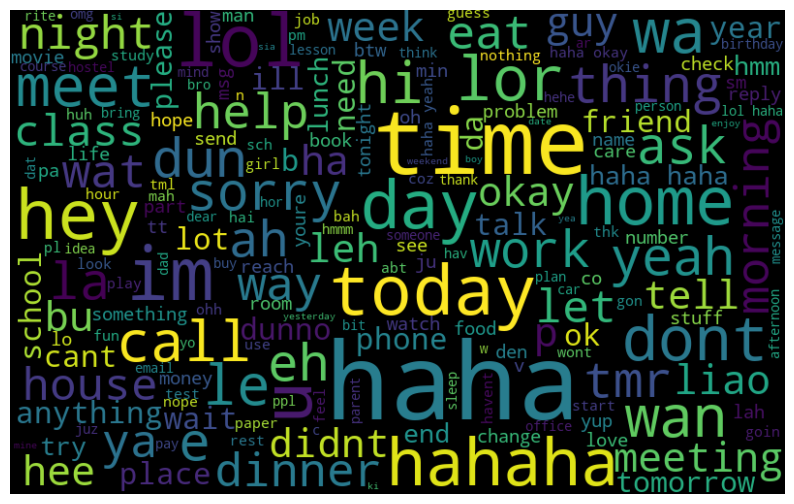

In [1963]:
#create wordcloud from nouns
all_nouns = ' '.join(nouns)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

POS tagging noun-phrases in message to view most common topics with a different method to see how it compares.

In [1964]:
#create pos tagged sentences from message_lemmatized_nostop
pos_tagged_sentences = []
for sentence in data['message_lemmatized_nostop']:
    pos_tagged_sentences.append(pos_tag(sentence))

In [1965]:
#create noun phrase chunker
chunk_grammar = 'NP: {<DT>?<JJ>*<NN>}'
chunk_parser = RegexpParser(chunk_grammar)

np_chunked = []
for sentence in pos_tagged_sentences:
    if sentence:
        np_chunked.append(chunk_parser.parse(sentence))
np_chunked[:10]        


[Tree('S', [Tree('NP', [('bugis', 'NN')]), Tree('NP', [('oso', 'NN')]), ('near', 'IN'), Tree('NP', [('wat', 'NN')])]),
 Tree('S', [('go', 'VB'), Tree('NP', [('jurong', 'JJ'), ('point', 'NN')]), Tree('NP', [('crazy', 'NN')]), Tree('NP', [('available', 'JJ'), ('bugis', 'NN')]), ('n', 'RB'), Tree('NP', [('great', 'JJ'), ('world', 'NN')]), Tree('NP', [('la', 'NN')]), ('e', 'VBP'), Tree('NP', [('buffet', 'JJ'), ('cine', 'NN')]), ('got', 'VBD'), ('amore', 'RB'), ('wat', 'JJ')]),
 Tree('S', [Tree('NP', [('dunno', 'NN')]), Tree('NP', [('let', 'NN')]), ('go', 'VB'), Tree('NP', [('learn', 'JJ'), ('pilate', 'NN')])]),
 Tree('S', [Tree('NP', [('den', 'JJ'), ('weekday', 'NN')]), ('got', 'VBD'), Tree('NP', [('special', 'JJ'), ('price', 'NN')]), Tree('NP', [('haiz', 'NN')]), Tree('NP', [('cant', 'JJ'), ('eat', 'NN')]), Tree('NP', [('liao', 'NN')]), Tree('NP', [('cut', 'NN')]), Tree('NP', [('nail', 'NN')]), Tree('NP', [('oso', 'NN')]), Tree('NP', [('muz', 'NN')]), ('wait', 'VBP'), Tree('NP', [('finish

In [1966]:
#extract chunks from np_chunked
chunks = []
for chunked_sentence in np_chunked:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'NP'):
            chunks.append(tuple(subtree))  
chunks[:10]             

[(('bugis', 'NN'),),
 (('oso', 'NN'),),
 (('wat', 'NN'),),
 (('jurong', 'JJ'), ('point', 'NN')),
 (('crazy', 'NN'),),
 (('available', 'JJ'), ('bugis', 'NN')),
 (('great', 'JJ'), ('world', 'NN')),
 (('la', 'NN'),),
 (('buffet', 'JJ'), ('cine', 'NN')),
 (('dunno', 'NN'),)]

Most common noun-phrases seems similar to using previous methods

In [1967]:
#create chunk counter
chunk_counter = Counter(chunks)
chunk_counter.most_common(20)

[((('haha', 'NN'),), 4675),
 ((('lol', 'NN'),), 1850),
 ((('u', 'NN'),), 1719),
 ((('im', 'NN'),), 1361),
 ((('hey', 'NN'),), 1256),
 ((('hahaha', 'NN'),), 1178),
 ((('home', 'NN'),), 1128),
 ((('time', 'NN'),), 994),
 ((('hi', 'NN'),), 966),
 ((('le', 'NN'),), 899),
 ((('today', 'NN'),), 888),
 ((('yeah', 'NN'),), 792),
 ((('call', 'NN'),), 717),
 ((('dont', 'NN'),), 709),
 ((('okay', 'NN'),), 694),
 ((('wa', 'NN'),), 683),
 ((('lor', 'NN'),), 681),
 ((('sorry', 'NN'),), 647),
 ((('r', 'NN'),), 640),
 ((('dun', 'NN'),), 635)]

Creating a setiment analysis using the 'SentimentIntensityAnalyzer' model from NLTK using the orginal messages and creating a new column named "sentiment".

In [1968]:
#Sentiment Analysis
sia = SentimentIntensityAnalyzer()
data['sentiment'] = data['Message'].apply(lambda x: sia.polarity_scores(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}"
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


Creating a new 'sentiment_tag' column to classify the message as positive, negative or neutral.

In [1969]:
#create column for positive, neutral, negative sentiment
data['sentiment_tag'] = data['sentiment'].apply(lambda x: 'positive' if x['compound'] > 0 else('neutral' if x['compound'] == 0 else 'negative'))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6...",positive
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral


Creating a plot to visualize the number of positive, negative and neutral messages as per the pre-trained model

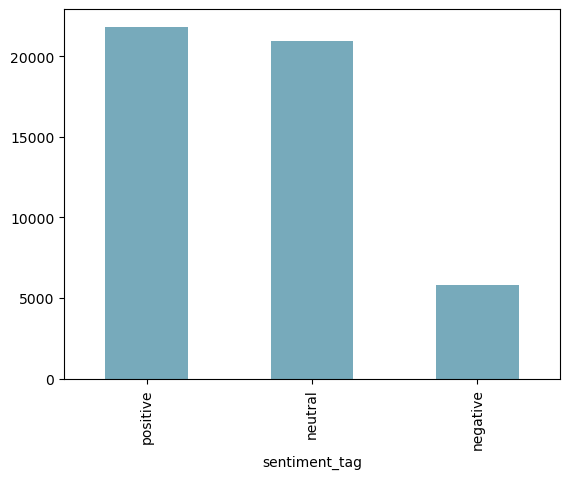

In [1970]:
#plot positive and negative sentiment 
data['sentiment_tag'].value_counts().plot(kind='bar')
plt.show()

In [1971]:
#sentiment_tag percentage
data['sentiment_tag'].value_counts(normalize=True)*100

sentiment_tag
positive    44.941206
neutral     43.106324
negative    11.952470
Name: proportion, dtype: float64

Creating a 'sentiment_score' column by extracting the 'compound' score

In [1972]:
#create sentiment score column 
data['sentiment_score'] = data['sentiment'].apply(lambda x: x['compound'])
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag,sentiment_score
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6...",positive,0.6249
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive,0.5445
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000


Creating a bar plot to visualize the sentiment scores by country to see which countries tend the send the most positive messages

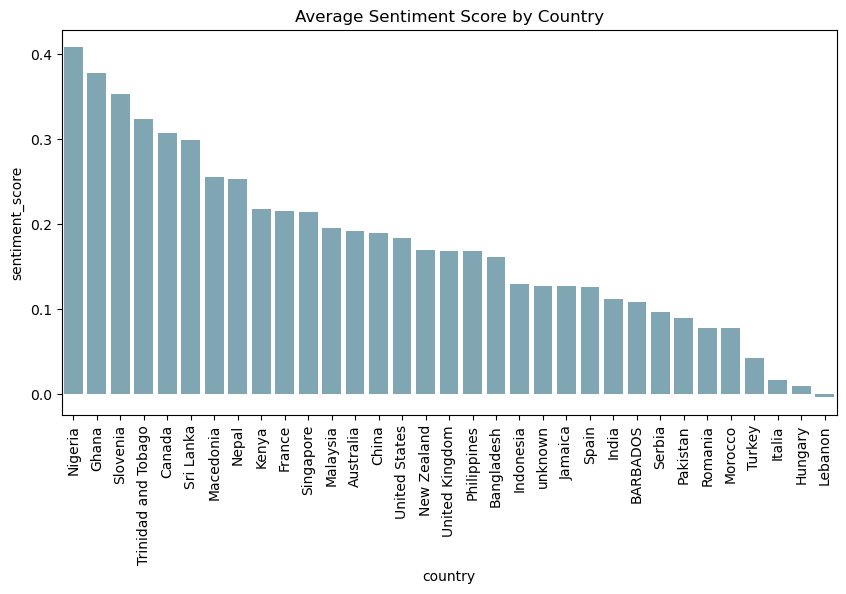

In [1973]:
#group by country and sentiment
country_sentiment = data.groupby(['country'])['sentiment_score'].mean().reset_index()
country_sentiment = country_sentiment.sort_values(by='sentiment_score', ascending=False)
# create a barplot for country and sentiment
plt.figure(figsize=(10, 5))
sns.barplot(x='country', y='sentiment_score', data=country_sentiment)  
plt.xticks(rotation=90)
plt.title('Average Sentiment Score by Country')
plt.show()

Filtering the dataframe to only include messages tagged as 'positive' and creating a wordcloud to visualize the most common words used in 'positive' messages.

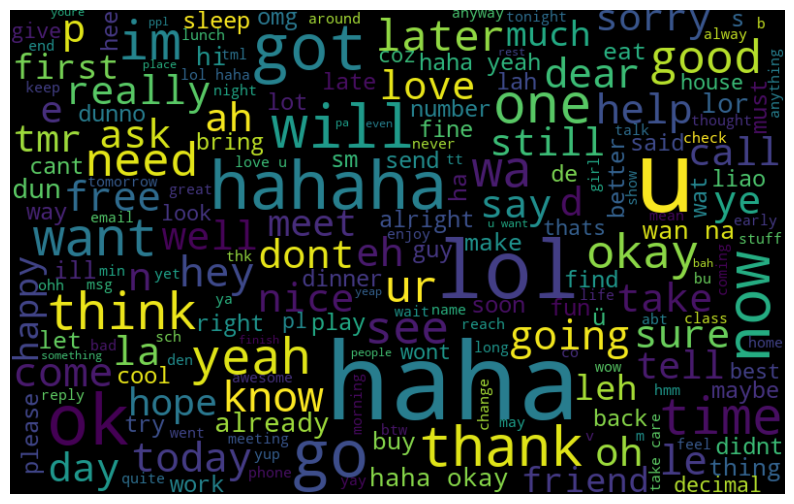

In [1974]:
#create wordcloud from message_lemmatized where sentiment is positive
pos_words = ' '.join([' '.join(text) for text in data[data['sentiment_tag'] == 'positive']['message_lemmatized']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Filtering the dataframe to only include messages tagged as 'negative' and creating a wordcloud to visualize the most common words used in 'negative' messages.

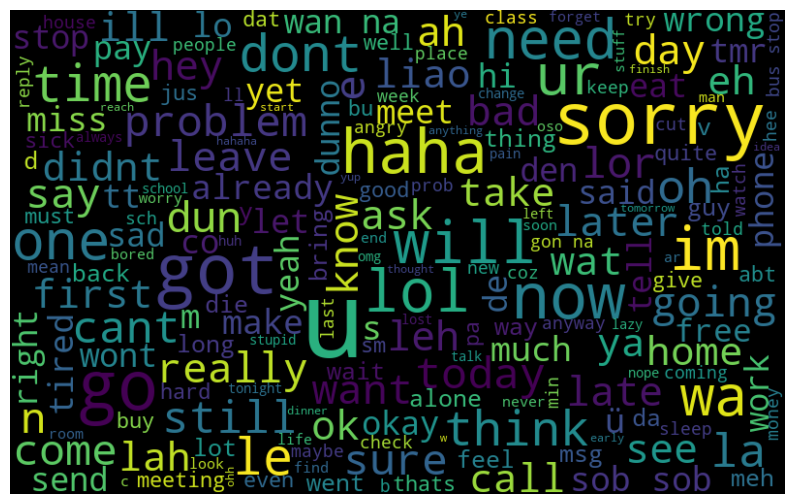

In [1975]:
#create wordcloud from message_lemmatized where sentiment is negative
neg_words = ' '.join([' '.join(text) for text in data[data['sentiment_tag'] == 'negative']['message_lemmatized']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Viewing a sample of messages classified as negative

In [1976]:
pd.set_option('display.max_colwidth', None)
#create dataframe of negative sentiment
negative_messages = data[data['sentiment_tag'] == 'negative']
negative_messages.Message[:20]

20                                                                                       Haiyoh... Maybe your hamster was jealous of million
21                                                                           is your hamster dead? Hey so tmr i meet you at 1pm orchard mrt?
36                                                       ll go yan jiu too... We can skip ard oso, go cine den go mrt one, blah blah blah...
39                                                                                             Haha... Sounds crazy, dunno can tahan anot...
41             Oh... I was thkin of goin yogasana at 10 den no nd to go at 3 den can rush to parco 4 nb... Okie lor, u call me when ready...
42                               After my work ah... Den 6 plus lor... U workin oso rite... Den go orchard lor, no other place to go liao...
49                                                           Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke
63     Oh... 

Viewing a sample of messages classified as positive

In [1977]:
pd.set_option('display.max_colwidth', None)
#create dataframe of positive sentiment
positive_messages = data[data['sentiment_tag'] == 'positive']
positive_messages.Message[:20]

1                                                     Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
3                        Den only weekdays got special price... Haiz... Cant eat liao... Cut nails oso muz wait until i finish drivin wat, lunch still muz eat wat...
10                                                                                                                          Oh...i asked for fun. Haha...take care. ü
16                                                 s a basic yoga course... at bugis... We can go for that... Pilates intro next sat.... Tell me what time you r free
22                                                                                                              ve booked the pilates and yoga lesson already... Haha
23                                                                            Yup... I havent been there before... You want to go for the yoga? I can call up to book
26  

Let's create our own model to see how it compares using the "Twitter Sentiment Dataset" by HUSSEIN, SHERIF (2021) found at https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

In [2128]:
#load twitter data and preview
twitter_df = pd.read_csv('Tweets.csv')
twitter_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


This dataset has 27,481 rows and 4 columns

In [2129]:
#check the shape
twitter_df.shape

(27481, 4)

Checking the distribution of sentiments.  The distribution is not even so we will address that below

In [2130]:
#check the distribution of category scores
twitter_df.sentiment.value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [2131]:
#check for missing values
twitter_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Dropping 1 row with null value

In [2132]:
#drop missing values
twitter_df = twitter_df.dropna()

Dropping columns that aren't needed

In [2133]:
#drop textID and selected_text columns
twitter_df = twitter_df.drop(['textID', 'selected_text'], axis=1)
twitter_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative


In [2134]:
#create copy of twitter_df
twitter_df2 = twitter_df
#drop null values
twitter_df2 = twitter_df2.dropna()

In [2135]:
#save sentiment tweets to new variable
negative_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'negative']
positive_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'positive'].sample(7781)
neutral_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'neutral'].sample(7781)

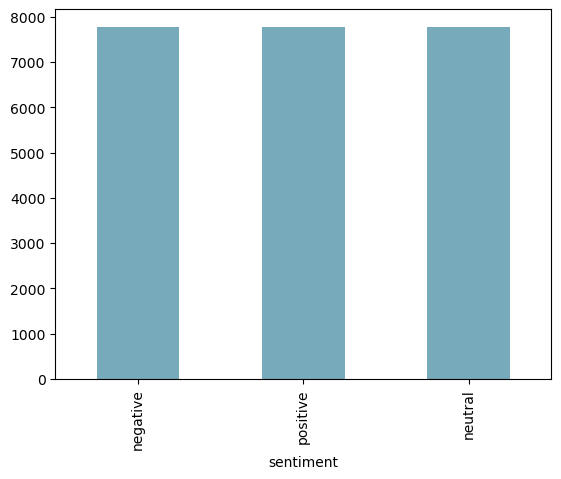

In [2136]:
#create new dataframe with all tweets
new_twitter_df2 = pd.concat([negative_tweets2, positive_tweets2, neutral_tweets2], ignore_index=True)

#plot distribution of sentiment
new_twitter_df2['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [2137]:
#shuffle dataframe
seed = 42
new_twitter_df2 = new_twitter_df2.sample(frac=1, random_state=seed).reset_index(drop=True)

new_twitter_df2.head()

,text,sentiment
0,"_Deen looks like a delicious recipe, will try that tonite",positive
1,"it`s a good mix of developers, content developers, providers and venture folks",positive
2,"Where`d the songs go on the site, I want 'Do You' on this computer too",neutral
3,"'somebody calls you, and you answer quite slowly, a girl with kaleidoscope eyes' yeah, im normal.",neutral
4,"_Company Hey Kathy, happy Mother`s Day!",positive


In [2138]:
#create new text_cleaned column with lowercased text
twitter_df2['text_cleaned'] = twitter_df2['text'].str.lower()
twitter_df2.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!
2,my boss is bullying me...,negative,my boss is bullying me...
3,what interview! leave me alone,negative,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"sons of ****, why couldn`t they put them on the releases we already bought"


In [2139]:
import emoji 
#convert emoticons to text
def convert_emojis(text):
    return emoji.demojize(text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: convert_emojis(x))

In [2140]:
#replace emoticon with dictionary key  
def replace_emoticons(text):
    emoticon_dict = {
        'smile' : [':-)', ':)', ':-]', ':]', ':->', ':>', '8-)', '8)', ':-}', ':}',	':^)','=]',	'=)', ':-))', ':))'],
        'laugh' : [':-D', ':D'],
        'sad' : [':-(', ':(', ':-c', ':c',	':-<', ':<', ':-[', ':[]', ':(', ';(', '</3'],
        'angry' : ['>:(', '>:[]'],
        'love' : ['<3', ]
    }
    for emotion, emoticon in emoticon_dict.items():
        for e in emoticon:
            text = text.replace(e, emotion)
    
    return text

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: replace_emoticons(x))

In [2141]:
#replace 3 or more consecutive letters with double letter   
def replace_consecutive_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: replace_consecutive_letters(x))

In [2142]:
#remove urls
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_url(x))

In [2143]:
#remove punctuation
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_punct(x))

In [2144]:
#create function to remove non letters from a-z
def remove_non_letters(text):
    return re.sub(r'[^a-z]', ' ', text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_non_letters(x))

In [2165]:
#tokenize
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: word_tokenize(x))

In [2167]:
#Lemmatize
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [2169]:
#remove stopwords from each row in text_cleaned from twitter_df2 
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_stopwords(x))

In [2170]:
twitter_df2.head(50)

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"[id, responded, going]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,negative,"[bos, bullying]"
3,what interview! leave me alone,negative,"[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"[son, couldnt, put, release, already, bought]"
5,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,neutral,"[shameless, plugging, best, ranger, forum, earth]"
6,2am feedings for the baby are fun when he is all smiles and coos,positive,"[feeding, baby, fun, smile, coo]"
7,Soooo high,neutral,"[soo, high]"
8,Both of you,neutral,[]
9,Journey!? Wow... u just became cooler. hehe... (is that possible!?),positive,"[journey, wow, u, became, cooler, hehe, possible]"


In [2188]:
#join tokenized text in text_cleaned column
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: ' '.join(x))
twitter_df2.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought


In [2171]:
#convert text column to lowercase
twitter_df['text_cleaned'] = twitter_df['text'].str.lower()

#Remove punctuation
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_punct(x))

#Remove urls
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_url(x))

#tokenize
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: tokenize(x))

#Lemmatize
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#Remove stopwords
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_stopwords(x))
twitter_df.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"[id, responded, going]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,negative,"[bos, bullying]"
3,what interview! leave me alone,negative,"[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"[son, couldnt, put, release, already, bought]"


In [2172]:
#save negative tweets to a new variable
negative_tweets = twitter_df[twitter_df['sentiment'] == 'negative']

In [2173]:
#save a random sample of 7781 positive tweets to a new variable
positive_tweets = twitter_df[twitter_df['sentiment'] == 'positive'].sample(7781)

In [2174]:
#save a random sample of 7781 neutral tweets to a new variable
neutral_tweets = twitter_df[twitter_df['sentiment'] == 'neutral'].sample(7781)

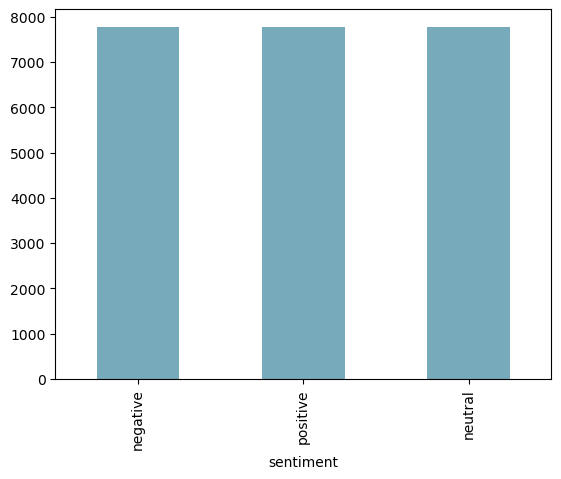

In [2175]:
#create new dataframe with all tweets
new_twitter_df = pd.concat([negative_tweets, positive_tweets, neutral_tweets], ignore_index=True)

#plot distribution of sentiment
new_twitter_df['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [2176]:
#shuffle dataframe
seed = 42
new_twitter_df = new_twitter_df.sample(frac=1, random_state=seed).reset_index(drop=True)

new_twitter_df.head()

,text,sentiment,text_cleaned
0,thanks :0 I will try,positive,"[thanks, 0, try]"
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]"
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]"
3,Ah....okay,neutral,[ahokay]
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]"


In [2177]:
#convert text_cleaned into strings
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned'].apply(lambda x: ' '.join(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,thanks :0 I will try,positive,"[thanks, 0, try]",thanks 0 try
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]",wa busy talking mom bhabhi liked card bro made waiting si get back church
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]",ahh feel good played guitar hero month suck haha
3,Ah....okay,neutral,[ahokay],ahokay
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]",obama ish funny


In [2178]:
#Define function to stem text_cleaned_str
def stem_text(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: stem_text(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,thanks :0 I will try,positive,"[thanks, 0, try]",thank 0 tri
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]",wa busi talk mom bhabhi like card bro made wait si get back church
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]",ahh feel good play guitar hero month suck haha
3,Ah....okay,neutral,[ahokay],ahokay
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]",obama ish funni


In [2179]:
#define function to remove repeating characters
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text) 

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: remove_repeating_char(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,thanks :0 I will try,positive,"[thanks, 0, try]",thank 0 tri
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]",wa busi talk mom bhabhi like card bro made wait si get back church
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]",ah fel god play guitar hero month suck haha
3,Ah....okay,neutral,[ahokay],ahokay
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]",obama ish funi


In [2180]:
#define function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: remove_numbers(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,thanks :0 I will try,positive,"[thanks, 0, try]",thank tri
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]",wa busi talk mom bhabhi like card bro made wait si get back church
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]",ah fel god play guitar hero month suck haha
3,Ah....okay,neutral,[ahokay],ahokay
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]",obama ish funi


In [2181]:
#create tokenized text_cleaned_str
new_twitter_df['text_cleaned_str_token'] = new_twitter_df['text_cleaned_str'].apply(lambda x: word_tokenize(x))
new_twitter_df.head()

/opt/anaconda3/envs/myenv2/lib/python3.11/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,text,sentiment,text_cleaned,text_cleaned_str,text_cleaned_str_token
0,thanks :0 I will try,positive,"[thanks, 0, try]",thank tri,"[thank, tri]"
1,was busy talking with mom and bhabhi.. they liked the cards bro and me made for them now waiting for sis to get back from Church..,positive,"[wa, busy, talking, mom, bhabhi, liked, card, bro, made, waiting, si, get, back, church]",wa busi talk mom bhabhi like card bro made wait si get back church,"[wa, busi, talk, mom, bhabhi, like, card, bro, made, wait, si, get, back, church]"
2,Ahh feels good to have played guitar hero after months! I suck at it now but haha,neutral,"[ahh, feel, good, played, guitar, hero, month, suck, haha]",ah fel god play guitar hero month suck haha,"[ah, fel, god, play, guitar, hero, month, suck, haha]"
3,Ah....okay,neutral,[ahokay],ahokay,[ahokay]
4,Obama is the ish!!!! he is funny!,positive,"[obama, ish, funny]",obama ish funi,"[obama, ish, funi]"


In [2182]:
X = new_twitter_df['text_cleaned_str']
y = new_twitter_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [2197]:
#create test and train sets from new_twitter_df2
X2 = twitter_df2['text_cleaned']
y2 = twitter_df2['sentiment']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=42)
y_train2.shape

(24732,)

In [2184]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=1.0,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('clf', MultinomialNB(alpha=8, class_prior=None, fit_prior=True))
])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6698072805139186

In [2245]:
#count vectorizer on twitter_df2
vectoriser = CountVectorizer(lowercase=True, max_df=0.9,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 2))
X2_train_counts = vectoriser.fit_transform(X_train2)
X2_test_counts = vectoriser.transform(X_test2)
X2_train_counts.shape



(24732, 5000)

In [2248]:
#tfidf transformer on twitter_df2
tfidf = TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)
X2_train_tfidf = tfidf.fit_transform(X2_train_counts)
X2_test_tfidf = tfidf.transform(X2_test_counts) 
X2_train_tfidf.shape

(24732, 5000)

In [2249]:
#create multinomialNB on twitter_df2
clf = MultinomialNB(alpha=2, class_prior=None, fit_prior=True)
clf.fit(X2_train_tfidf, y_train2)
y_pred = clf.predict(X2_test_tfidf)
score = clf.score(X2_test_tfidf, y_test2)
print('Score:', accuracy)
accuracy = accuracy_score(y_test2, y_pred)
print('Accuracy:', accuracy)

Score: 0.6473799126637555
Accuracy: 0.6448326055312955


In [2251]:
#create LinearSVC on twitter_df2
clf2 = svm.LinearSVC()
clf2.fit(X2_train_tfidf, y_train2)
y_pred = clf2.predict(X2_test_tfidf)
score = clf2.score(X2_test_tfidf, y_test2)
print('Score:', accuracy)
accuracy = accuracy_score(y_test2, y_pred)
print('Accuracy:', accuracy)

Score: 0.6448326055312955
Accuracy: 0.6666666666666666


In [2252]:
#create Random Forest on twitter_df2
clf3 = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42,
                                   criterion='gini', max_features='sqrt')
clf3.fit(X2_train_tfidf, y_train2)
y_pred = clf3.predict(X2_test_tfidf)
score = clf3.score(X2_test_tfidf, y_test2)
print('Score:', accuracy)
accuracy = accuracy_score(y_test2, y_pred)
print('Accuracy:', accuracy)

Score: 0.6666666666666666
Accuracy: 0.6972343522561864


In [2258]:
#SentimentIntensityAnalyzer with twitter_df2
sia2 = SentimentIntensityAnalyzer()
twitter_df2['pred_scores'] = twitter_df2['text'].apply(lambda x: sia.polarity_scores(x))
twitter_df2.head()


,text,sentiment,text_cleaned,pred_scores
0,"I`d have responded, if I were going",neutral,id responded going,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.7437}"
2,my boss is bullying me...,negative,bos bullying,"{'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}"
3,what interview! leave me alone,negative,interview leave alone,"{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.3595}"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [2261]:
#create predicted sentiment column
twitter_df2['pred_senti'] = twitter_df2['pred_scores'].apply(lambda x: 'positive' if x['compound'] > 0.05 else ('neutral' if x['compound'] > -0.05 else 'negative'))
twitter_df2.head()

,text,sentiment,text_cleaned,pred_scores,pred_senti
0,"I`d have responded, if I were going",neutral,id responded going,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.7437}",negative
2,my boss is bullying me...,negative,bos bullying,"{'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}",negative
3,what interview! leave me alone,negative,interview leave alone,"{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.3595}",negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral


In [2262]:
score = accuracy_score(twitter_df2['sentiment'], twitter_df2['pred_senti'])
score

0.631259097525473

In [ ]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe2 = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=0.8,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('rfc', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42,
                                   criterion='gini', max_features='sqrt'))
])
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.7143468950749464

In [ ]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe3 = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=1.0,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('svm', svm.LinearSVC())
])
pipe3.fit(X_train, y_train)
pipe3.score(X_test, y_test)

0.691220556745182

In [2264]:
#use pipe2 to predict sentiment on data 
y_pred = pipe2.predict(data['Message'])
y_pred.shape

(48559,)

In [2265]:
#create pipe2_pred column in data
data['pipe2_pred'] = y_pred
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag,sentiment_score,pipe2_pred
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6249}",positive,0.6249,positive
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral
3,3,10123,"Den only weekdays got special price... Haiz... Cant eat liao... Cut nails oso muz wait until i finish drivin wat, lunch still muz eat wat...",140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao cut nails oso muz wait until i finish drivin wat lunch still muz eat wat,"[den, only, weekdays, got, special, price, haiz, cant, eat, liao, cut, nails, oso, muz, wait, until, i, finish, drivin, wat, lunch, still, muz, eat, wat]","[den, only, weekday, got, special, price, haiz, cant, eat, liao, cut, nail, oso, muz, wait, until, i, finish, drivin, wat, lunch, still, muz, eat, wat]","[den, weekday, got, special, price, haiz, cant, eat, liao, cut, nail, oso, muz, wait, finish, drivin, wat, lunch, still, muz, eat, wat]","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive,0.5445,negative
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral


In [2266]:
#get percentage of each sentiment from pipe2_pred
data['pipe2_pred'].value_counts(normalize=True)

pipe2_pred
neutral     0.742787
negative    0.146111
positive    0.111102
Name: proportion, dtype: float64

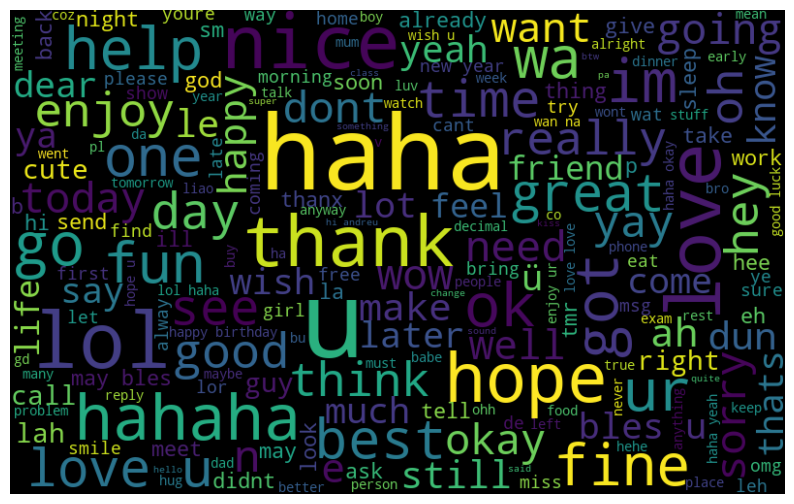

In [2269]:
#create wordcloud from pipe2_pred where sentiment is positive
pos_words = ' '.join([' '.join(text) for text in data[data['pipe2_pred'] == 'positive']['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

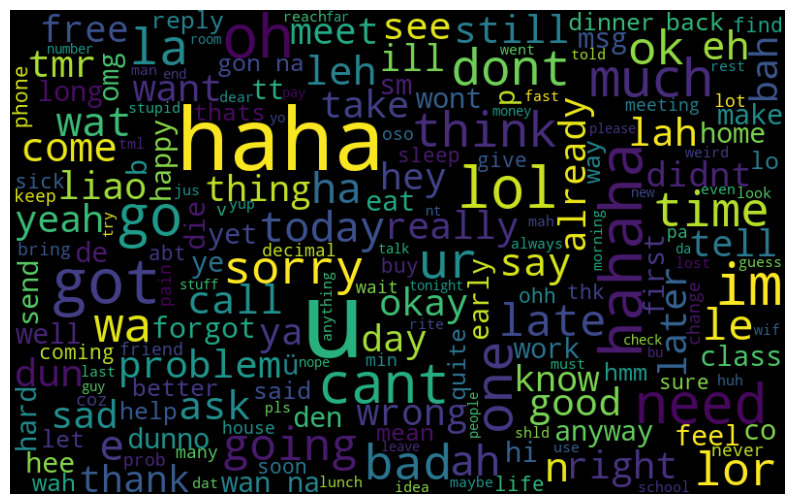

In [2270]:
#create wordcloud from pipe2_pred where sentiment is negative
neg_words = ' '.join([' '.join(text) for text in data[data['pipe2_pred'] == 'negative']['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [2272]:
#preview random sample of messages where pipe2_pred is negative
data.Message[data['pipe2_pred'] == 'negative'].sample(10)   

44074                                                                      You've seen less eyecancer than me, trust me on that.
17011                   You only hate me. You can call any but you didnt accept even a single call of mine. Or even you messaged
38089                                                                                                                        No*
18086                                                 He's just gonna worry for nothing. And he won't give you money its no use.
15877                                                                                  tune ana ha? main mohsin ka wait kar raha
40190                                                                                                                       Com*
4017                                                                             m trying 2 do everything by myself? So selfish?
17031                                                                                     Am i th

In [2275]:
#preview random sample of messages where pipe2_pred is positive
data.Message[data['pipe2_pred'] == 'positive'].sample(10)

28479                                                                                                    Hahahha ok.then jiu morning lo.hahaha I nv expect to like pass oso.haha.
12078                                                                                                                                                         Thank you princess!
41302    Haha I woke up at <#> (: at bk eating breakfast now! Oh my suddenrealisation how to do one of the biochem exam questions omg! HahahaOMG DAMN CUTE. CAN I DO THAT TO YOU.
34518                                                                                      I'll talk to you tomorrow! I'm just so tired. I really love you. Somuch. Goodnight :))
33588                                                                                    awsome! His sheep hear His voice. It is not fantacy! Hold on. Thankyou for sharing. GBU.
34854             Hi Sis, I've sent you the new wet kitchen layout according to ourdiscussion yesterday night 